<img src=https://www.universidadviu.com/sites/universidadviu.com/themes/custom/universidadviu_com/logo.webp style="height: 100px">
<center style="color:#888">Master en Bigdata y  Data Science<br/>Trabajo Final de Master 2022</center>

## **Identificación de oportunidades de compra en el mercado inmobiliario para alquiler**

**Autor:** Luis Eduardo Rodriguez<br/>
**Módulo:** Modelado/Entrenamiento y Validacio  Alquiler

### **Descripcion:**

En el siguiente libro se hace entrenamiento  del mejor modelo obtenido "GradientBoosting Regression" para el set de Alquileres,  luego se usa el modelo para hacer las predicciones sobre el set de Ventas,  se calcula los KPIs de rentabilidad  y se exporta el data set para su visualizacion

Addicionalmente, se incluye el feature importance segmentado por grupo  de variables: num, cat properyType, cat pmdistric (Top10) y Total (Top10) 


### **Librerias**

In [1]:
#Cargamos librerias con todo lo necesario.
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from datetime import datetime
from sklearn.metrics import explained_variance_score

### **Carga de Datos**

Se carga la data colectada con Api idealista

In [2]:
#Lectura CSVs  desde directorio data desde donde esta guardado el libro, todos tiene las mismas columnas
df = pd.DataFrame()
for csv_file in Path('.').glob('data/*.csv'):
    df_aux = pd.read_csv(csv_file, index_col=None, header=0)
    df = df.append(df_aux, ignore_index=True, sort=False)
#df inicial
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9391 entries, 0 to 9390
Data columns (total 40 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Unnamed: 0              9391 non-null   int64  
 1   propertyCode            9391 non-null   int64  
 2   thumbnail               9328 non-null   object 
 3   externalReference       7401 non-null   object 
 4   numPhotos               9391 non-null   int64  
 5   floor                   8427 non-null   object 
 6   price                   9391 non-null   float64
 7   propertyType            9391 non-null   object 
 8   operation               9391 non-null   object 
 9   size                    9391 non-null   float64
 10  exterior                9391 non-null   bool   
 11  rooms                   9391 non-null   int64  
 12  bathrooms               9391 non-null   int64  
 13  address                 9391 non-null   object 
 14  province                9391 non-null   

### **Limpieza de Datos**

Se aplica todos los cambios  del analisis exploratorio

In [3]:
#Eliminación de features innecesarias
dropcolumns = ['Unnamed: 0', 'thumbnail', 'externalReference', 'numPhotos', 'country',
               'hasVideo', 'newDevelopment','suggestedTexts', 'hasPlan', 'has3DTour',
               'has360', 'hasStaging', 'topNewDevelopment', 'labels', 'newDevelopmentFinished',
              'showAddress', 'priceByArea']
df = df.drop(columns=dropcolumns)

#Eliminación de duplicados
df = df.drop_duplicates(subset="url", keep='first')

#transformación de floors a números enteros y redondeamos a 1 decimal
df['floor'] = df['floor'].replace({'en': 0.5, 'bj': 0, 'ss': -0.5, 'st': -1}).astype(float)
df['floor'] = df['floor'].fillna(df['floor'].mean())
df['floor'] = df['floor'].round(decimals = 1)

#variables campos vacios con false.
df['hasLift'] = df['hasLift'].fillna(False)

#remplazamos Nulos por "{'hasParkingSpace': False, 'isParkingSpaceIncludedInPrice': False}"
df['parkingSpace'] = df['parkingSpace'].fillna("{'hasParkingSpace': False, 'isParkingSpaceIncludedInPrice': False}")

#Convertimos  Parking Space en: hasParkingSpace, isParkingSpaceIncludedInPrice, luego lo removemos
df_aux = df['parkingSpace'].str.split(n=4, expand=True)
df_aux.columns =['h1', 'hasParkingSpace', 'h2', 'isParkingSpaceIncludedInPrice', 'h3']
df_aux['hasParkingSpace'] = df_aux['hasParkingSpace'].replace({'False,': 'False', 'True,': 'True'})
df_aux['isParkingSpaceIncludedInPrice'] = df_aux['isParkingSpaceIncludedInPrice'].replace({'False}': 'False', 'False,': 'False', 'True}': 'True'})
df = pd.concat([df,df_aux[['hasParkingSpace', 'isParkingSpaceIncludedInPrice']]], axis=1).drop(['parkingSpace','isParkingSpaceIncludedInPrice'], axis=1)

# Sustituimos NAN en status por "good"
df['status'] = df['status'].fillna("good")

# Sustituimos NAN en distrito por municipalidades. y en vecindario por distrito
df['district'] = df['district'].fillna(df['municipality'])
df['neighborhood'] = df['neighborhood'].fillna(df['district'])

#Convertimos  detailType en los subgrupos Typology y Subtypology, remplazamos nan  de SubTypology por Typology
df_aux = df['detailedType'].str.split(n=3, expand=True)
df_aux.columns =['h1', 'typology', 'h2', 'subTypology']
df_aux['typology'] = df_aux['typology'].replace({"'chalet',": 'chalet', "'chalet'}": 'chalet',
                                                 "'flat',": 'flat', "'flat'}": 'flat',
                                                 "'countryHouse',": 'countryHouse', "'countryHouse'}": 'countryHouse'})
df_aux['subTypology'] = df_aux['subTypology'].replace({"'casaTerrera'}": 'casaTerrera', "'casale'}": 'casale',
                                                       "'countryHouse'}": 'countryHouse', "'duplex'}": 'duplex',
                                                       "'independantHouse'}": 'independantHouse', "'studio'}": 'studio',
                                                      "'terracedHouse'}": 'terracedHouse', "'penthouse'}": 'penthouse',
                                                      "'semidetachedHouse'}": 'semidetachedHouse'})
df_aux['subTypology'] = df_aux['subTypology'].fillna(df_aux['typology'])

df = pd.concat([df,df_aux[['typology', 'subTypology']]], axis=1).drop(['detailedType','typology'], axis=1)

#Transformamos en variables numéricas  todas  las tipo binario (True or False)
columns = df.loc[: , (df == 'False').any()].columns
for column in columns:
    df[column] = df[column].map({'True': True, 'False': False})
columns = df.select_dtypes('bool').columns
for column in columns:
    df[column] = df[column].astype(float)

#Filtrado de Muestras de barcelona  distance < 5000
df = df[((df['province']=="Barcelona") & (df['distance']<5000)) | (df['province']=="Madrid")]

#Insersion de variable logprice
df['Logprice'] = np.log(df.price.values)

#Quitamos Outlier, para viviendas en venta y alquiler valores obtenidos del analisis exploratorio:
cleaned_df = df[((df['operation']=="rent") & (df['price']<4730)) | (df['operation']=="sale")]
cleaned_df = cleaned_df[((cleaned_df['operation']=="sale") & (cleaned_df['price']<1691000)) | (cleaned_df['operation']=="rent")]

#Quitamos Outlier en el tamaño, en este caso pisos mayores a 296m2
cleaned_df = cleaned_df[cleaned_df['size'] < 296]
#Quitamos Outliers, que vemos que son pisos con más de 9 cuartos
cleaned_df = cleaned_df[cleaned_df['rooms'] <= 9]
#Quitamos Outliers, que vemos que son pisos con más de 5 baños
cleaned_df = cleaned_df[cleaned_df['bathrooms'] <= 5]
#Quitamos Outliers, que vemos que son pisos con más de 13 pisos
cleaned_df = cleaned_df[cleaned_df['floor'] <= 13]

#df  final despues de la limpieza
cleaned_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7620 entries, 0 to 9389
Data columns (total 24 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   propertyCode     7620 non-null   int64  
 1   floor            7620 non-null   float64
 2   price            7620 non-null   float64
 3   propertyType     7620 non-null   object 
 4   operation        7620 non-null   object 
 5   size             7620 non-null   float64
 6   exterior         7620 non-null   float64
 7   rooms            7620 non-null   int64  
 8   bathrooms        7620 non-null   int64  
 9   address          7620 non-null   object 
 10  province         7620 non-null   object 
 11  municipality     7620 non-null   object 
 12  district         7620 non-null   object 
 13  neighborhood     7620 non-null   object 
 14  latitude         7620 non-null   float64
 15  longitude        7620 non-null   float64
 16  url              7620 non-null   object 
 17  distance      

In [4]:
cleaned_df.columns

Index(['propertyCode', 'floor', 'price', 'propertyType', 'operation', 'size',
       'exterior', 'rooms', 'bathrooms', 'address', 'province', 'municipality',
       'district', 'neighborhood', 'latitude', 'longitude', 'url', 'distance',
       'description', 'status', 'hasLift', 'hasParkingSpace', 'subTypology',
       'Logprice'],
      dtype='object')

### Regresion Preparation
Creamos una variable ProvMunDist concat(Province-Municipality-Distric)   para evitar duplicidades
Calculamos el precio medio del distrito, luego decidimos cual usar

In [5]:
#Columnas iniciales hay que guardar el df original de las propiedades en venta al final para incluir las predicciones del alquiler
cleaned_df.columns

Index(['propertyCode', 'floor', 'price', 'propertyType', 'operation', 'size',
       'exterior', 'rooms', 'bathrooms', 'address', 'province', 'municipality',
       'district', 'neighborhood', 'latitude', 'longitude', 'url', 'distance',
       'description', 'status', 'hasLift', 'hasParkingSpace', 'subTypology',
       'Logprice'],
      dtype='object')

In [6]:
regressor_df = cleaned_df.copy()

#Creación de Variables sintéticas para agrupar Province|Municipality|District|Neighbourhood
regressor_df['pmdistrict'] = regressor_df['province'] + '|' + regressor_df['municipality'] + '|' +  regressor_df['district']
regressor_df['pmdneigh'] = regressor_df['province'] + '|' + regressor_df['municipality'] + '|' +  regressor_df['district'] + '|' +  regressor_df['neighborhood']

In [7]:
#Convertimos estas variables a dummies 
regressor_df = pd.get_dummies(regressor_df, columns=['pmdistrict'])
regressor_df = pd.get_dummies(regressor_df, columns=['propertyType'])

In [8]:
#convertimos todos estos campos a ENTEROS y rellenamos con False los nulos.

regressor_df['bathrooms'] = regressor_df['bathrooms'].astype(float)
regressor_df['rooms'] = regressor_df['rooms'].astype(float)
regressor_df['distance'] = regressor_df['distance'].astype(float)

In [9]:
# Seleccionamos features,  esta vez con Logprice
fdrop=['propertyCode', 'price', 'pmdneigh', 'address', 'province', 'municipality',
       'district', 'neighborhood', 'latitude', 'longitude', 'url', 'description', 'status', 'subTypology']
regressor_df = regressor_df.drop(fdrop, axis=1)
#features=['operation', 'floor', 'Logprice', 'size', 'exterior', 'rooms', 'bathrooms', 'distance', 
#          'hasLift', 'hasParkingSpace', 'propertyType', 'pmdistrict']



In [10]:
regressor_df.info(verbose=True, show_counts=True)


<class 'pandas.core.frame.DataFrame'>
Int64Index: 7620 entries, 0 to 9389
Data columns (total 170 columns):
 #    Column                                                                     Non-Null Count  Dtype  
---   ------                                                                     --------------  -----  
 0    floor                                                                      7620 non-null   float64
 1    operation                                                                  7620 non-null   object 
 2    size                                                                       7620 non-null   float64
 3    exterior                                                                   7620 non-null   float64
 4    rooms                                                                      7620 non-null   float64
 5    bathrooms                                                                  7620 non-null   float64
 6    distance                                      

### **Separamos Datos de Ventas y Alquiler**

In [11]:
#separamos el dataset por los dos tipos de operación y borramos la etiqueta, para este modulo solo trabajos con alquiler

df_rent = regressor_df[regressor_df['operation']== 'rent']
df_rent = df_rent.drop('operation', axis=1)

df_sale = regressor_df[regressor_df['operation']== 'sale']
df_sale = df_sale.drop('operation', axis=1)

rent_df_regresion = df_rent.copy()
sale_df_regresion = df_sale.copy()

In [12]:
# Revisamos la dimensionaliad
print('rent dim',rent_df_regresion.shape)
print('sale dim',sale_df_regresion.shape)

rent dim (4236, 169)
sale dim (3384, 169)


### Separamos df en entrenamiento  y test (30%)

In [13]:
from sklearn.model_selection import train_test_split

#En el dataset Y incluimos los datos a predecir, que es el rango de precios
df_y = rent_df_regresion['Logprice']
dataset_y = np.array(df_y)

#En el dataset X borramos la varible a predecir
dataset_X = rent_df_regresion.drop('Logprice', axis=1) #para el entrenamiento
dataset_Xs = sale_df_regresion.drop('Logprice', axis=1) #para las predicciones

#Usamos RobustScaler
from sklearn.preprocessing import RobustScaler
rs = RobustScaler()
rent_df_regresion_robust = rs.fit_transform(dataset_X)
sale_df_regresion_robust = rs.transform(dataset_Xs) #se usa el mismo scaler ajustado al set de entrenamiento para las predicciones

#Generamos los datos de Entrenamiento y Test, al 70 - 30
X_train, X_test, y_train, y_test = train_test_split(rent_df_regresion_robust, dataset_y, test_size=.3, random_state=42)

print('entrenamiento:',len(X_train))
print('prueba:',len(X_test))
print('prediccion:',len(sale_df_regresion_robust))

entrenamiento: 2965
prueba: 1271
prediccion: 3384


### Funcion para evaluar los resultados del entrenamiento

In [14]:
def print_metrics(model, X_train, y_train, X_test, y_test, predictions, prediction_train, dataset_X, dataset_y):
    
    rmse = np.sqrt(mean_squared_error(predictions, y_test))
    r2 = r2_score(predictions, y_test)
    evs = explained_variance_score(predictions, y_test)
    mae_train = mean_absolute_error(y_train,prediction_train)
    mae_test = mean_absolute_error(y_test,predictions)
    # Perform K-Fold CV
    scores = cross_val_score(model, dataset_X, dataset_y, cv=5, scoring='r2')
    
    print("RMSE:                 %f" % (rmse))
    print("R2:                   %f" % (r2))
    print("R2 con cross val:     %f" % (scores.mean()))
    print("Varianza explicada:   %f" % (evs))
    print("MAE_train:            %f" % (mae_train))
    print("MAE_test:             %f" % (mae_test))
    
    fig, axe = plt.subplots(1,2,figsize=(10, 4))
    axe[0].scatter(y_train, prediction_train, alpha=0.2)
    axe[0].plot([y_train.min(), y_train.max()], [prediction_train.min(), prediction_train.max()], "--r", linewidth=2)
    axe[0].set_xlabel("Measured")
    axe[0].set_ylabel("Predicted")
    axe[0].title.set_text("Training Set")
    axe[1].scatter(y_test, predictions, alpha=0.2)
    axe[1].plot([y_test.min(), y_test.max()], [predictions.min(), predictions.max()], "--r", linewidth=2)
    axe[1].set_xlabel("Measured")
    axe[1].set_ylabel("Predicted")
    axe[1].title.set_text("Test Set")
    plt.show()

### Preparamos el entorno

In [15]:
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import cross_val_score, cross_val_predict, GridSearchCV
from sklearn.model_selection import validation_curve
from sklearn.metrics import precision_score
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.metrics import SCORERS
import scikitplot as skplt

### Entrenamiento

BestModel: GradientBoostingRegressor

In [16]:
#Instanciamos el modelo con los mejores resultados obtenidos
gbr = GradientBoostingRegressor(learning_rate = 0.02, n_estimators = 1000,  max_depth = 6, 
                                random_state = 42, loss = 'huber', max_features = 0.1, 
                                min_samples_leaf = 3)

In [17]:
#Entrenamos
gbr.fit(X_train, y_train)

GradientBoostingRegressor(learning_rate=0.02, loss='huber', max_depth=6,
                          max_features=0.1, min_samples_leaf=3,
                          n_estimators=1000, random_state=42)

In [18]:
#Calculamos las predicciones
predictions_gbr_test = gbr.predict(X_test)#Realizamos métricas para comprobar lo buenos que es nuestro modelo
predictions_gbr_train = gbr.predict(X_train)

Text(0.5, 0, 'Gboost Feature Importance- Top10')

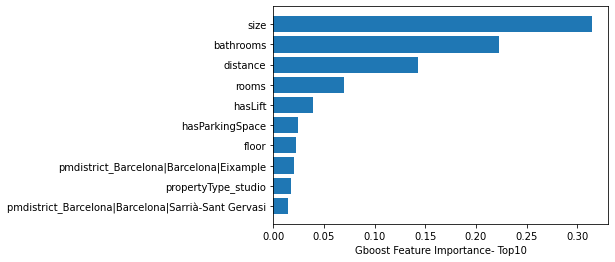

In [78]:
features= gbr.feature_importances_
names = np.array(dataset_X.columns)
sort_idx = gbr.feature_importances_.argsort()
test_idx =  [17, 167,   9,   0,   7,   6,   3,   5,   4,   1]
#plt.barh(names, features)

#plt.barh(names[sort_idx], features[sort_idx])
plt.barh(names[test_idx], features[test_idx])
plt.xlabel("Gboost Feature Importance- Top10")
#sort_idx

Text(0.5, 0, 'Gboost Feature Importance- Only Num')

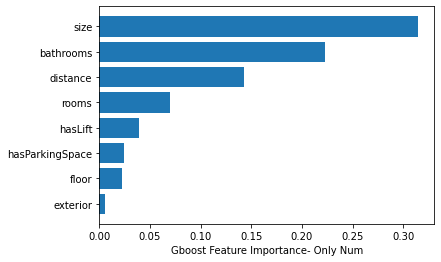

In [86]:
features= gbr.feature_importances_
names = np.array(dataset_X.columns)
sort_idx = gbr.feature_importances_.argsort()
test_idx =  [2,   0,   7,   6,   3,   5,   4,   1]
#plt.barh(names, features)

#plt.barh(names[sort_idx], features[sort_idx])
plt.barh(names[test_idx], features[test_idx])
plt.xlabel("Gboost Feature Importance- Only Num")
#sort_idx

Text(0.5, 0, 'Gboost Feature Importance-Cat_PropertyType')

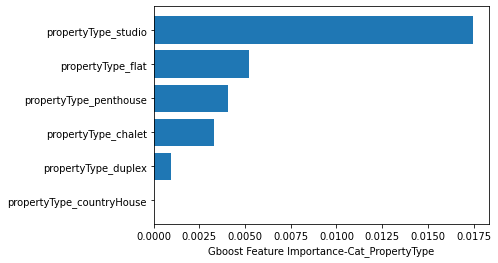

In [81]:
features= gbr.feature_importances_
names = np.array(dataset_X.columns)
sort_idx = gbr.feature_importances_.argsort()
test_idx =  [163, 164,  162, 166, 165, 167]
#plt.barh(names, features)

#plt.barh(names[sort_idx], features[sort_idx])
plt.barh(names[test_idx], features[test_idx])
plt.xlabel("Gboost Feature Importance-Cat_PropertyType")
#sort_idx

Text(0.5, 0, 'Gboost Feature Importance-Cat_pmdistrict top10')

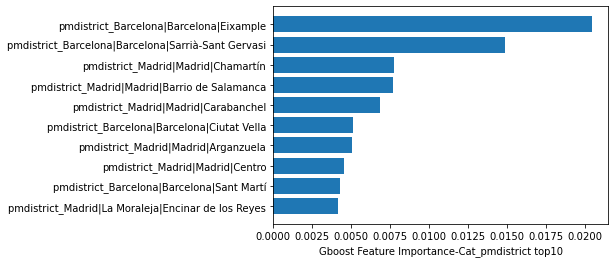

In [82]:
features= gbr.feature_importances_
names = np.array(dataset_X.columns)
sort_idx = gbr.feature_importances_.argsort()
test_idx =  [68,  15,  87,  83,   8,  86,
        85,  88,  17, 9]
#plt.barh(names, features)

#plt.barh(names[sort_idx], features[sort_idx])
plt.barh(names[test_idx], features[test_idx])
plt.xlabel("Gboost Feature Importance-Cat_pmdistrict top10")
#sort_idx

In [38]:
sort_idx

array([ 79, 118, 117, 116, 114, 113, 112, 110, 109, 107, 106,  82, 119,
        81, 157,  78,  77,  76,  73,  72,  64,  63,  62,  61,  60,  80,
       120, 121, 122, 156, 155, 153, 152, 151, 149, 148, 146, 145, 144,
       143, 142, 141, 139, 138, 135, 134, 133, 131, 129, 127, 126, 125,
       124, 123,  59,  58, 158,  38,  44,  43,  39,  41,  40,  22,  24,
        31,  32,  33,  34,  35,  36,  37,  56,  45,  46,  42,  52, 163,
        51,  18, 161,  49,  50,  53,  54,  48,  55, 159,  20,  25, 111,
        21,  27,  23,  26, 104, 115, 108, 147, 136,  70,  69,  29,  74,
        13,  57,  71,  19, 130,  65,  75, 150, 137,  30,  47, 105,  28,
        97, 154, 101,  14, 140, 103, 132,  91, 160, 164,  99,  66,  95,
        94,  11, 128,  92,  84,  93,  10, 100,  90,  12,  98,  16, 102,
        89, 162,  67,  96, 166,  68,  15,  87,  83,   8, 165,   2,  86,
        85,  88,  17, 167,   9,   0,   7,   6,   3,   5,   4,   1],
      dtype=int64)

RMSE:                 0.225962
R2:                   0.661907
R2 con cross val:     0.717960
Varianza explicada:   0.661927
MAE_train:            0.127541
MAE_test:             0.165513


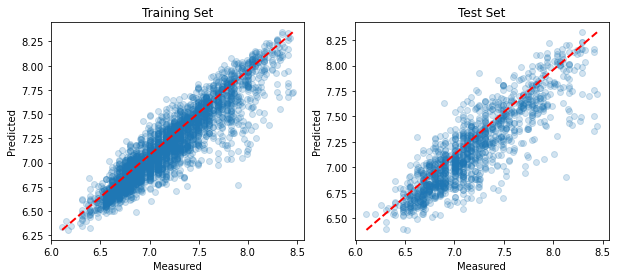

In [65]:
# Revisamos metricas
print_metrics(gbr, X_train, y_train, X_test, y_test, predictions_gbr_test, predictions_gbr_train, dataset_X, dataset_y)

### Hacemos predicciones sobre el set the ventas (sales)

In [138]:
#Predicciones
predictions_sales = gbr.predict(sale_df_regresion_robust)

# data sales  desde cleand_df eliminando logprice, operacion y nos quedamos con sales
clean_sale_df = cleaned_df[cleaned_df['operation']== 'sale']
clean_sale_df = clean_sale_df.reset_index(drop=True, inplace=False)
clean_sale_df = clean_sale_df.drop(['operation','Logprice'], axis=1)

#convertimos predictions_sales en natural redondeado
predicted_rent = np.round_(np.exp(predictions_sales))
b=pd.DataFrame(predicted_rent)
b.columns = ['price_rent']

#añadimos al dataset original
output_sale_df = clean_sale_df.join(b)

output_sale_df.head()


,propertyCode,floor,price,propertyType,size,exterior,rooms,bathrooms,address,province,...,latitude,longitude,url,distance,description,status,hasLift,hasParkingSpace,subTypology,price_rent
0,96875682,2.0,249000.0,flat,64.0,0.0,2,1,Calle del General Zabala,Madrid,...,40.443704,-3.676197,https://www.idealista.com/inmueble/96875682/,3769,"Piso en Madrid zona Ciudad Jardin, 64 m. de su...",good,0.0,0.0,flat,1172.0
1,96879576,0.0,131050.0,flat,60.0,1.0,1,1,Centro,Madrid,...,40.285956,-3.793258,https://www.idealista.com/inmueble/96879576/,16428,Apartamento amplio en el centro de Fuenlabrada...,good,1.0,0.0,flat,698.0
2,96879820,0.0,71000.0,flat,32.0,0.0,1,1,barrio Palos de Moguer,Madrid,...,40.400080,-3.689272,https://www.idealista.com/inmueble/96879820/,2224,"Inmobiliaria Eduardo Molet, pone en exclusiva ...",renew,0.0,0.0,flat,719.0
3,96879990,3.0,500000.0,flat,95.0,1.0,3,2,barrio Las Tablas,Madrid,...,40.511908,-3.668224,https://www.idealista.com/inmueble/96879990/,10975,"Don Piso ofrece, amplio piso en una de las mej...",good,1.0,0.0,flat,1128.0
4,96880045,0.0,192400.0,flat,117.0,1.0,1,1,barrio Campodón - Ventorro del Cano,Madrid,...,40.390765,-3.839375,https://www.idealista.com/inmueble/96880045/,11868,LUMINOSO LOFT EN ALCORCON donpiso vende bonito...,good,0.0,0.0,flat,840.0


### Calculamos indicadores y los añadimos al dset



formulas:

RB_% (Rentabilidad Bruta): 100 * 12 *(price_rent / price)


PRI (Tiempo recuperacion años) : price / (12 * price_rent)

In [139]:
output_sale_df['RB_%'] = 1200 * output_sale_df.price_rent / output_sale_df.price
output_sale_df['PRI_yr'] = output_sale_df.price / (12 * output_sale_df.price_rent)
output_sale_df['PRI_yr'] = output_sale_df['PRI_yr'].round()
#.astype(float)

In [140]:
print('sales_dset original:',clean_sale_df.shape)
print('sales_dset after:',output_sale_df.shape)
#print('prediccion:',len(predictions_sales))


sales_dset original: (3384, 22)
sales_dset after: (3384, 25)


In [141]:
output_sale_df.head()

,propertyCode,floor,price,propertyType,size,exterior,rooms,bathrooms,address,province,...,url,distance,description,status,hasLift,hasParkingSpace,subTypology,price_rent,RB_%,PRI_yr
0,96875682,2.0,249000.0,flat,64.0,0.0,2,1,Calle del General Zabala,Madrid,...,https://www.idealista.com/inmueble/96875682/,3769,"Piso en Madrid zona Ciudad Jardin, 64 m. de su...",good,0.0,0.0,flat,1172.0,5.648193,18.0
1,96879576,0.0,131050.0,flat,60.0,1.0,1,1,Centro,Madrid,...,https://www.idealista.com/inmueble/96879576/,16428,Apartamento amplio en el centro de Fuenlabrada...,good,1.0,0.0,flat,698.0,6.391454,16.0
2,96879820,0.0,71000.0,flat,32.0,0.0,1,1,barrio Palos de Moguer,Madrid,...,https://www.idealista.com/inmueble/96879820/,2224,"Inmobiliaria Eduardo Molet, pone en exclusiva ...",renew,0.0,0.0,flat,719.0,12.152113,8.0
3,96879990,3.0,500000.0,flat,95.0,1.0,3,2,barrio Las Tablas,Madrid,...,https://www.idealista.com/inmueble/96879990/,10975,"Don Piso ofrece, amplio piso en una de las mej...",good,1.0,0.0,flat,1128.0,2.707200,37.0
4,96880045,0.0,192400.0,flat,117.0,1.0,1,1,barrio Campodón - Ventorro del Cano,Madrid,...,https://www.idealista.com/inmueble/96880045/,11868,LUMINOSO LOFT EN ALCORCON donpiso vende bonito...,good,0.0,0.0,flat,840.0,5.239085,19.0


In [143]:
#Guardamos resultados en csv

import datetime
fileresult = 'prediction_results' + '_' + datetime.datetime.today().strftime('%Y-%m-%d-%H-%M') + '.csv'
output_sale_df.to_csv(fileresult, index=False)